#  
# LAB 6
#  


## Part A / Part B

This assignment uses a convolutional neural network for image colorization which
turns a grayscale image to a colored image.1 By converting an image to grayscale,
we loose color information, so converting a grayscale image back to a colored
version is not an easy job. We will use the CIFAR-10 dataset. Downolad the
dataset from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz.

From the train and test dataset, extract the class birds. We will focus on this
class, which has 6000 members.

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


In [2]:
def load_birds(cifar10_dataset_path):
    #open file and go to that batch number file
    with open(cifar10_dataset_path, mode = 'rb') as file:
        batch = pickle.load(file, encoding='latin1')
    # store it if the label is 2, aka if it is a bird
    filtered = np.asarray([x for (i, x) in enumerate(batch['data']) if batch['labels'][i] == 2])
    file_features = filtered.reshape((len(filtered), 3, 32, 32)).transpose(0, 2, 3, 1)
    file_labels = np.asarray([x for x in batch['labels'] if x == 2])
    return file_features, file_labels

(6000, 32, 32, 3)
(6000,)


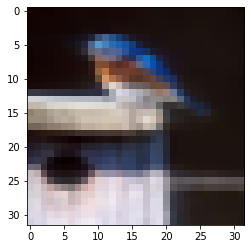

In [3]:
# feature and labels np array for holding data
labels = []
features = []

X_features = []
y_labels = []

for i in range(1, 7):
    #read the test data batch
    if i == 6:
        file_features, file_labels = load_birds('../data/cifar-10-batches-py/test_batch')
        X_features = np.append(features, file_features, axis=0)
        y_labels = np.append(labels, file_labels)
        continue
    #otherwise read the train data batch
    file_features, file_labels = load_birds('../data/cifar-10-batches-py/data_batch_' + str(i))
    if i == 1:
        features = file_features
        labels = file_labels
        continue
    features = np.append(features, file_features, axis=0)
    labels = np.append(labels, file_labels)



print(X_features.shape)
print(y_labels.shape)

plt.imshow(X_features[1])


##  
## Part C

Those 6000 images have 6000 × 32 × 32 pixels. Choose at least 10% of the pixels
randomly. It is strongly recommended that you choose a large number or all of
the pixels. You will have between P = 614400 and P = 6144000 pixels. Each
pixel is an RGB vector with three elements.

In [4]:
# choose random amount of of the pixels; i.e. P = 61440
import random
#10%
#randomsample = random.sample(range(0, len(X_features)*32*32), (int)(0.1*len(X_features)*32*32))
randomsample = [i for i in range(0,(len(X_features) * 32 * 32))]

pixels = np.empty([len(randomsample),3], dtype=int)
for i in range(0, len(randomsample)):
    sample = randomsample[i]
    rbg = X_features[(int)(sample/1024)][int((sample%1024)/32)][(sample%1024)%32].astype(int)
    pixels[i] = rbg
    if(i%614400 == 0):
        print(int((i/len(randomsample))*100), "% done")
print("100% done")

print(pixels.shape)


0 % done
10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100% done
(6144000, 3)


##  
## Part D
Run k-means clustering on the P vectors using k = 4. The centers of the clusters
will be your main colors. Convert the colored images to k-color images by converting each pixel’s value to the closest main color in terms of Euclidean distance.
These are the outputs of your network, whose each pixel falls in one of those k
classes

In [5]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(pixels)
labels = kmeans.predict(pixels)

In [6]:
X_features_copy = X_features.copy()
color_map = kmeans.cluster_centers_

for i in range(0, len(labels)):
    color = (color_map[labels[i]]).astype(int)
    X_features_copy[int(i/1024)][int((i%1024)/32)][int((i%1024)%32)] = color
    

before example


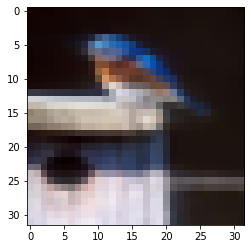

In [7]:
print("before example")
plt.imshow(X_features[1])

transformed example:


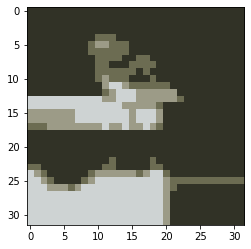

In [8]:
print("transformed example:")
plt.imshow(X_features_copy[1])

##  
## Part E
Use any tool (e.g., openCV or scikit-learn) to obtain grayscale 32 × 32 × 1 images
from the original 32 × 32 × 3 images. The grayscale images are inputs of your
network.

Before:


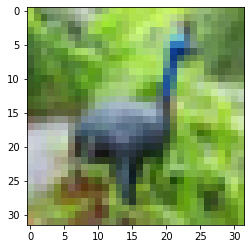

In [9]:
from skimage.color import rgb2gray

X_features_greyscale = np.empty([len(X_features),32,32,1])

for image in range (0, len(X_features)):
    X_features_greyscale[image] = rgb2gray(X_features[image]).reshape(32,32,1)

print("Before:")
plt.imshow(X_features[0])

After:


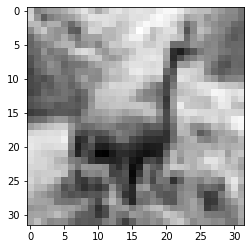

In [10]:
print("After:")
greyscale_copy = X_features_greyscale.reshape(len(X_features),32,32)
plt.imshow(greyscale_copy[0],cmap=plt.cm.gray)

##  
## Part F
Set up a deep convolutional neural network with two convolution layers (or more)
and two (or more) MLP layers. Use 5 × 5 filters and a softmax output layer.
Determine the number of filters, strides, and whether or not to use padding yourself. Use a minimum of one max pooling layer. Use a classification scheme, which
means your output must determine one of the k = 4 color classes for each pixel in
your grayscale image. Your input is a grayscale version of an image (32 × 32 × 1)
and the output is 32 × 32 × 4. The output assigns one of the k = 4 colors to
each of the 32 × 32 pixels; therefore, each of the pixels is classified into one of the
classes [1 0 0 0], [0 1 0 0], [0 0 1 0], [0 0 0 1]. After each pixel is classified into one
of the main colors, the RGB code of that color can be assigned to the pixel. For
example, if the third main color 3
is [255 255 255] and pixel (32,32) of an image
has the one-hot encoded class [0 0 1 0], i.e it was classified as the third color, the
(32,32) place in the output can be associated with [255 255 255]. The size of the
output of the convolutional part, c1 × c2 depends on the size of the convolutional
layers you choose and is a feature map, which is a matrix. That matrix must be
flattened or reshaped, i.e. must be turned into a vector of size c1c2 ×1, before it is
fed to the MLP part. Choose the number of neurons in the first layer of the MLP
(and any other hidden layers, if you are willing to have more than one hidden
layer) yourself, but the last layer must have 32 × 32 × 4 = 4096 neurons, each of
which represents a pixel being in one of the k = 4 classes. Add a softmax layer4
which will choose the highest value out of its k = 4 inputs for each of the 1024
pixels; therefore, the output of the MLP has to be reshaped into a 32 × 32 × 4
matrix, and to get the colored image, the RGB vector of each of the k = 4 classes
has to be converted to the RGB vector, so an output image will be 32 × 32 × 3.
Train at least for 5 epochs (30 epochs is strongly recommended). Plot training,
(validation), and test errors in each epoch. Report the train and test errors and
visually compare the artificially colored versions of the first 10 images in the test
set with the original images.5

In [11]:
!pip install tensorflow --ignore-installed
!pip install keras
import keras
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

  Using cached https://files.pythonhosted.org/packages/2c/72/6b3264aa2889b7dde7663464b99587d95cd6a5f3b9b30181f14d78a63e64/tensorflow-2.0.0-cp37-cp37m-macosx_10_11_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/60/9a/a6b3168f2194fb468dcc4cf54c8344d1f514935006c3347ede198e968cb0/numpy-1.17.4-cp37-cp37m-macosx_10_9_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/28/6a/8c1f62c37212d9fc441a7e26736df51ce6f0e38455816445471f10da4f0a/Keras_Preprocessing-1.1.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/76/54/99b9d5d52d5cb732f099baaaf7740403e83fe6b0cedde940fabd2b13d75a/tensorboard-2.0.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/c3/fd/1e86bc4837cc9a3a5faf3db9b1854aa04ad35b5f381f9648fbe81a6f94e4/google_pasta-0.1.8-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/fc/08/8b927337b7019c374719145d1dceba21a8bb909b93b1ad6f8fb7d22c1ca1/tensorflow_estimator-2.0.1-py2.py3-none-any.whl
  U

Using TensorFlow backend.


Establish train and test data and labels, with labels being {0,1,2,3} to represent the four colors found in K-Means 
in part D.

In [12]:
from keras.utils import to_categorical
train_X = X_features_greyscale[:5000]
train_y = to_categorical(labels[:(5000*32*32)]).reshape(5000, 1024, 4).astype(int)
test_X = X_features_greyscale[-1000:]
test_y = to_categorical(labels[-(1000*32*32):]).reshape(1000, 1024, 4).astype(int)

print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)


(5000, 32, 32, 1)
(5000, 1024, 4)
(1000, 32, 32, 1)
(1000, 1024, 4)


In [17]:
from keras import optimizers

print(train_X.shape)
print(train_y.shape)

model = models.Sequential()
#CNN stuff
model.add(layers.Conv2D(32, (5, 5), padding="same", activation='relu', input_shape=(32, 32, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
#MLP stuff
model.add(layers.Dense(1024,activation='relu'))
model.add(layers.Dense(4096))
model.add(layers.Reshape((1024, 4)))
#SOFTMAX used here
model.add(layers.Softmax(axis=-1))
model.summary()


#optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_X, train_y, epochs=30, validation_data=(test_X, test_y))


(5000, 32, 32, 1)
(5000, 1024, 4)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 32)        832       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 32)        25632     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 2, 32)          25632     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
flatten_1 (Flatten) 

##  
Plot training, (validation), and test errors in each epoch. Report the train and test errors and visually compare the artificially colored versions of the first 10 images in the test set with the original images.

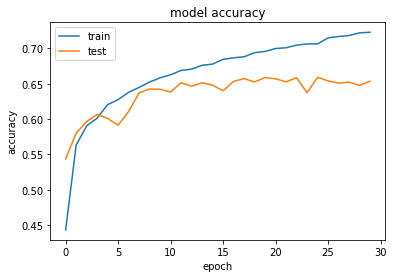

1000/1 - 0s - loss: 0.8404 - accuracy: 0.6535


In [18]:
#ACCURACY AND VALUE ACCURACY aka the test and train data
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

test_loss, test_acc = model.evaluate(test_X,  test_y, verbose=2)


#### After:

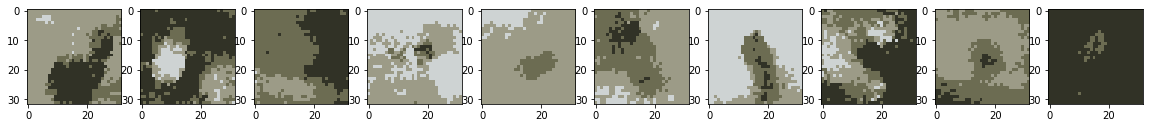

In [20]:
first10test = (X_features_greyscale[-1000:])[:10]

predictions = model.predict(first10test)

predictions = predictions.reshape(10, 32, 32, 4)

predictions_color_convert = np.empty([len(predictions), 32, 32, 3], dtype=int)

for image in range (0, len(predictions)):
    for row in range (0, 32):
        for col in range (0, 32):
            current_prediction = predictions[image][row][col]
            if current_prediction.tolist().index(max(current_prediction)) == 0:
                predictions_color_convert[image][row][col] = color_map[0]
            elif current_prediction.tolist().index(max(current_prediction)) == 1:
                predictions_color_convert[image][row][col] = color_map[1]
            elif current_prediction.tolist().index(max(current_prediction)) == 2:
                predictions_color_convert[image][row][col] = color_map[2]
            elif current_prediction.tolist().index(max(current_prediction)) == 3:
                predictions_color_convert[image][row][col] = color_map[3]


plt.figure(figsize=(20,20))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.grid(False)
    plt.imshow(predictions_color_convert[i], cmap=plt.cm.binary)
plt.show()

#### Before:

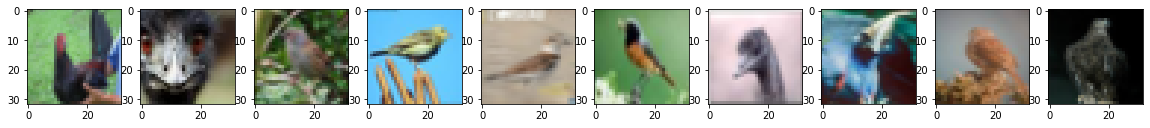

In [21]:
cpy = (X_features[-1000:])[:10]
plt.figure(figsize=(20,20))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.grid(False)
    plt.imshow(cpy[i], cmap=plt.cm.binary)
plt.show()